# Testing the effects of synapse and scaling_firing_rates on the accuracy of a converted spiking convolutional network.

## Initialize data

In [2]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf
import nengo_dl

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
tf.keras.backend.clear_session()

In [4]:
# obtain images
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

# normalize data by color channel
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

train_images_R = normalize(train_images.transpose()[0].transpose())
train_images_G = normalize(train_images.transpose()[1].transpose())
train_images_B = normalize(train_images.transpose()[2].transpose())
test_images_R = normalize(test_images.transpose()[0].transpose())
test_images_G = normalize(test_images.transpose()[1].transpose())
test_images_B = normalize(test_images.transpose()[2].transpose())

train_images = np.array([train_images_R, train_images_G, train_images_B])
test_images = np.array([test_images_R, test_images_G, test_images_B])

train_images = np.moveaxis(train_images, 0, -1)
test_images = np.moveaxis(test_images, 0, -1)

# verify normalization
print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))
print('test mean:', np.mean(train_images))
print('test stdv:', np.std(train_images))
print('train mean:', np.mean(test_images))
print('train stdv:', np.std(test_images))

((50000, 32, 32, 3), (50000, 1)) ((10000, 32, 32, 3), (10000, 1))
test mean: 5.4830214442821065e-17
test stdv: 1.0000000000000002
train mean: 8.14903700074865e-18
train stdv: 1.0000000000000002


In [5]:
# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))

((50000, 1, 3072), (50000, 1, 1)) ((10000, 1, 3072), (10000, 1, 1))


## Build network and convert to nengo-dl

In [6]:
inp = tf.keras.Input(shape=(32, 32, 3))

conv0 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=tf.nn.relu)(inp)

pool0 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(skip0)

conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=tf.nn.relu)(pool0)
pool1 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=2, activation=tf.nn.relu)(pool1)
pool2 = tf.keras.layers.AveragePooling2D(pool_size=(2,2))(conv2)

flatten = tf.keras.layers.Flatten()(pool2)

dense0 = tf.keras.layers.Dense(units=300, activation=tf.nn.relu)(flatten)
out = tf.keras.layers.Dense(units=10)(dense0)

model = tf.keras.Model(inputs=inp, outputs=out)

In [7]:
converter = nengo_dl.Converter(model)

## Train the non-spiking network

In [8]:
with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.Adam(0.001),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.sparse_categorical_accuracy]
    )

    sim.fit(
        {converter.inputs[inp]: train_images},
        {converter.outputs[out]: train_labels},
        validation_data=({converter.inputs[inp]: test_images}, {converter.outputs[out]: test_labels}),
        epochs=20
    )

    # save the parameters
    sim.save_params("./equal_cnn_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/20
250/250 [==============================] - 36s 78ms/step - loss: 1.8804 - probe_loss: 1.8804 - probe_sparse_categorical_accuracy: 0.3228 - val_loss: 1.3881 - val_probe_loss: 1.3881 - val_probe_sparse_categorical_accuracy: 0.4935
Epoch 2/20
250/250 [==============================] - 27s 108ms/step - loss: 1.3620 - probe_loss: 1.3620 - probe_sparse_categorical_accuracy: 0.5126 - val_loss: 1.2629 - val_probe_loss: 1.2629 - val_probe_sparse_categorical_accuracy: 0.5420
Epoch 3/20
250/250 [==============================] - 17s 66ms/step - loss: 1.2355 - probe_loss: 1.2355 - probe_sparse_categorical_accuracy: 0.5632 - val_loss: 1.1757 - val_probe_loss: 1.1757 - val_probe_sparse_categorical_accuracy: 0.5793
Epoch 4/20
250/250 [===================

## Run the non-spiking network

In [9]:
def run_network(
    activation,
    params_file="equal_cnn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[out]

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f"    Test accuracy: {100 * accuracy:.2f}%")

    return accuracy

In [10]:
baseline_accuracy = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

    Test accuracy: 73.25%


## Apply synaptic smoothing and scale firing rates

In [11]:
# specify the size of the grid: (synapse, scale_firing_rates)
grid_size = (5, 10)
scaling_baseline = 1
synapse_increment = 0.005

synapse_values = [synapse_increment*x for x in range(grid_size[0])]
scale_firing_rates_values = range(20, 120, 10)
accuracy_grid = []

for synapse in synapse_values:
    print(f"synapse={synapse:.3f}")
    accuracy_grid.append([])

    for scale_firing_rates in scale_firing_rates_values:
        print(f"  scale_firing_rates={scale_firing_rates:.3f}")
        accuracy = run_network(
            activation=nengo.SpikingRectifiedLinear(),
            n_steps=60,
            synapse=synapse,
            scale_firing_rates=scale_firing_rates)         
        accuracy_grid[-1].append(accuracy)

synapse=0.000
  scale_firing_rates=20.000
    Test accuracy: 11.00%
  scale_firing_rates=30.000
    Test accuracy: 12.25%
  scale_firing_rates=40.000
    Test accuracy: 11.00%
  scale_firing_rates=50.000
    Test accuracy: 11.25%
  scale_firing_rates=60.000
    Test accuracy: 15.25%
  scale_firing_rates=70.000
    Test accuracy: 14.00%
  scale_firing_rates=80.000
    Test accuracy: 11.75%
  scale_firing_rates=90.000
    Test accuracy: 15.00%
  scale_firing_rates=100.000
    Test accuracy: 16.00%
  scale_firing_rates=110.000
    Test accuracy: 14.25%
synapse=0.005
  scale_firing_rates=20.000
    Test accuracy: 7.50%
  scale_firing_rates=30.000
    Test accuracy: 14.00%
  scale_firing_rates=40.000
    Test accuracy: 32.50%
  scale_firing_rates=50.000
    Test accuracy: 44.75%
  scale_firing_rates=60.000
    Test accuracy: 50.00%
  scale_firing_rates=70.000
    Test accuracy: 57.75%
  scale_firing_rates=80.000
    Test accuracy: 60.25%
  scale_firing_rates=90.000
    Test accuracy: 63.00%

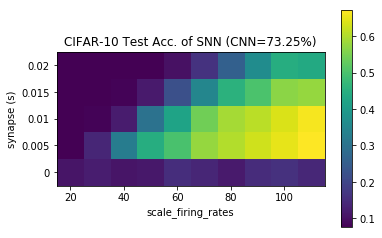

In [13]:
accuracy_grid = np.matrix(accuracy_grid)

fig, ax = plt.subplots(1,1)

plt.xlabel("scale_firing_rates")
plt.ylabel("synapse (s)")
plt.title("CIFAR-10 Test Acc. of SNN (CNN=73.25%)")

ax.set_xticklabels([20, 20, 40, 60, 80, 100, 120])
ax.set_yticklabels([0, 0, 0.005, 0.010, 0.015, 0.020])

img = ax.imshow(accuracy_grid, origin='lower')
fig.colorbar(img)
plt.savefig("./images/egalitarian_conv_accuracy_grid", dpi=400)